<a href="https://colab.research.google.com/github/Aniket982-ux/RUL/blob/main/Copy_of_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras

# Unzip the archive
with zipfile.ZipFile("/content/archive (1).zip", "r") as z:
    z.extractall("/content/archive2")

# Paths
data_path = "/content/archive2/CMaps"


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow.keras.callbacks as callbacks


In [ ]:
def process_targets(data_length, early_rul=None):
    if early_rul is None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul * np.ones(shape=(early_rul_duration,)), np.arange(early_rul-1, -1, -1))

def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats=num_batches * window_length * num_features).reshape(num_batches, window_length, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(shift*batch):(shift*batch+window_length), :]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(shift*batch):(shift*batch+window_length), :]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length) / shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, num_test_windows


In [ ]:
fds = ["FD003"]
train_list = []
offset = 0
for fd in fds:
    df = pd.read_csv("/content/archive2/CMaps/train_" + fd + ".txt", sep="\s+", header=None)
    df[0] = df[0] + offset
    offset = df[0].max() + 1
    train_list.append(df)
train_data = pd.concat(train_list, ignore_index=True)
columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
train_data_first_column = train_data[0]
scaler_train = StandardScaler()
train_data_scaled = scaler_train.fit_transform(train_data.drop(columns=columns_to_be_dropped))
train_data = pd.DataFrame(np.c_[train_data_first_column, train_data_scaled])


In [ ]:
test_list = []
rul_list = []
offset = 0
for fd in fds:
    df = pd.read_csv("/content/archive2/CMaps/test_" + fd + ".txt", sep="\s+", header=None)
    df[0] = df[0] + offset
    offset = df[0].max() + 1
    rul_df = pd.read_csv("/content/archive2/CMaps/RUL_" + fd + ".txt", sep="\s+", header=None)
    test_list.append(df)
    rul_list.append(rul_df)
test_data = pd.concat(test_list, ignore_index=True)
true_rul = pd.concat(rul_list, ignore_index=True)
test_data_first_column = test_data[0]
scaler_test = StandardScaler()
test_data_scaled = scaler_test.fit_transform(test_data.drop(columns=columns_to_be_dropped))
test_data = pd.DataFrame(np.c_[test_data_first_column, test_data_scaled])


In [ ]:
window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []
num_train_machines = len(train_data[0].unique())
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns=[0]).values
    orig_length = len(temp_train_data)
    if orig_length < window_length:
        pad_len = window_length - orig_length
        padded_train_data = np.pad(temp_train_data, ((pad_len, 0), (0, 0)), mode='constant', constant_values=0)
        temp_train_targets = process_targets(data_length=orig_length, early_rul=early_rul)
        padded_train_targets = np.pad(temp_train_targets, (pad_len, 0), mode='constant', constant_values=0)
    else:
        padded_train_data = temp_train_data
        padded_train_targets = process_targets(data_length=orig_length, early_rul=early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(padded_train_data, padded_train_targets, window_length=window_length, shift=shift)
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)


In [ ]:
num_test_windows = 30
processed_test_data = []
num_test_windows_list = []
num_test_machines = len(test_data[0].unique())
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns=[0]).values
    orig_length = len(temp_test_data)
    if orig_length < window_length:
        pad_len = window_length - orig_length
        padded_test_data = np.pad(temp_test_data, ((pad_len, 0), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_test_data = temp_test_data
    test_data_for_an_engine, num_windows = process_test_data(padded_test_data, window_length=window_length, shift=shift, num_test_windows=num_test_windows)
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul # or true_rul = true_rul[0] if you want the first element only


In [ ]:
index = np.random.permutation(len(processed_train_targets))
processed_train_data = processed_train_data[index]
processed_train_targets = processed_train_targets[index]
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=83)


In [ ]:
def scheduler(epoch, lr):
    return lr

def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape=(window_length, 14), return_sequences=True, activation="tanh"),
        layers.LSTM(64, activation="tanh", return_sequences=True),
        layers.LSTM(32, activation="tanh"),
        layers.Dense(96, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

callback_lr = callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs=100, validation_data=(processed_val_data, processed_val_targets), callbacks=[callback_lr, early_stop], batch_size=128, verbose=1)
model.save("best_model.h5")




Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6057.8633

KeyboardInterrupt: 

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)


89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step
RMSE:  27.860974715793237


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


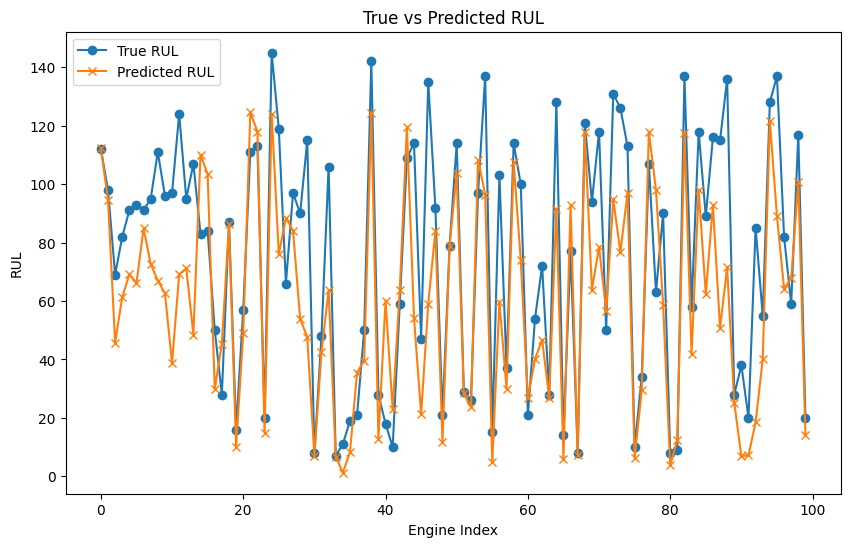

In [ ]:
import matplotlib.pyplot as plt
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
plt.figure(figsize=(10,6))
plt.plot(true_rul, marker="o", label="True RUL")
plt.plot(mean_pred_for_each_engine, marker="x", label="Predicted RUL")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL")
plt.legend()
plt.show()


In [ ]:
def scheduler(epoch, lr):
    return lr

def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape=(window_length, 14), return_sequences=True, activation="tanh"),
        layers.LSTM(64, activation="tanh", return_sequences=True),
        layers.LSTM(32, activation="tanh"),
        layers.Dense(96, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

callback_lr = callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs=100, validation_data=(processed_val_data, processed_val_targets), callbacks=[callback_lr, early_stop], batch_size=128, verbose=1)
model.save("best_model.h5")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 4024.0955 - val_loss: 1723.7120 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1754.5126 - val_loss: 1729.4001 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1758.8214 - val_loss: 1714.4208 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1757.6796 - val_loss: 1724.2423 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1759.6566 - val_loss: 1713.9055 - learning_rate: 0.0010

Epoch 6: 

622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE:  60.05514533179595
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


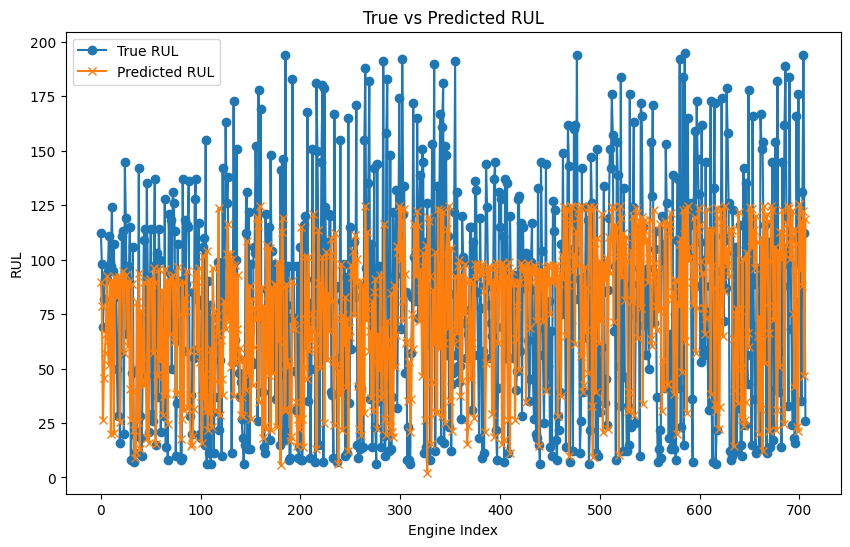

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)
import matplotlib.pyplot as plt
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
plt.figure(figsize=(10,6))
plt.plot(true_rul, marker="o", label="True RUL")
plt.plot(mean_pred_for_each_engine, marker="x", label="Predicted RUL")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL")
plt.legend()
plt.show()

In [ ]:
def scheduler(epoch, lr):
    return lr

def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape=(window_length, 14), return_sequences=True, activation="tanh"),
        layers.LSTM(64, activation="tanh", return_sequences=True),
        layers.LSTM(32, activation="tanh"),
        layers.Dense(96, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

callback_lr = callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs=100, validation_data=(processed_val_data, processed_val_targets), callbacks=[callback_lr, early_stop], batch_size=128, verbose=1)
model.save("best_model.h5")



NameError: name 'callbacks' is not defined

622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE:  60.05514533179595
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


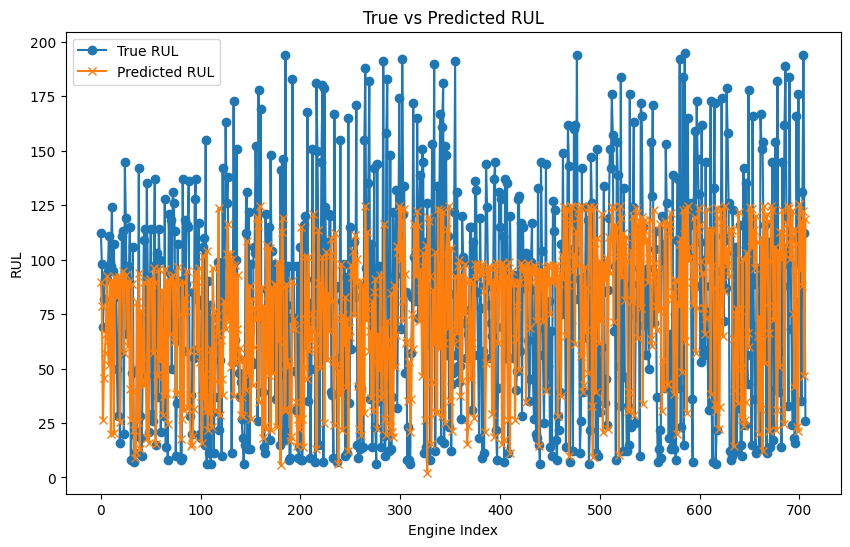

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)
import matplotlib.pyplot as plt
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls, weights=np.repeat(1/num, num)) for ruls, num in zip(preds_for_each_engine, num_test_windows_list)]
plt.figure(figsize=(10,6))
plt.plot(true_rul, marker="o", label="True RUL")
plt.plot(mean_pred_for_each_engine, marker="x", label="Predicted RUL")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow.keras.callbacks as callbacks


In [ ]:
def create_sequences(df, features, window_length, is_train=True):
    X, y = [], []
    for unit in df["unit"].unique():
        sub = df[df["unit"] == unit].sort_values("time").reset_index(drop=True)
        if is_train:
            target = sub["RUL"].values
        for i in range(len(sub) - window_length + 1):
            X.append(sub.iloc[i:i+window_length][features].values)
            if is_train:
                y.append(target[i+window_length-1])
    return np.array(X), (np.array(y) if is_train else None)

def get_last_windows(df, features, window_length):
    X_list, units = [], []
    for unit in df["unit"].unique():
        sub = df[df["unit"] == unit].sort_values("time").reset_index(drop=True)
        if len(sub) < window_length:
            pad_len = window_length - len(sub)
            # Replace repeat with tile and convert back to DataFrame
            padded_rows = pd.DataFrame(np.tile(sub.iloc[[0]].values, (pad_len, 1)), columns=sub.columns)
            sub = pd.concat([padded_rows, sub], ignore_index=True)
        X_list.append(sub.iloc[-window_length:][features].values)
        units.append(unit)
    return np.array(X_list), units

import tensorflow as tf
from tensorflow.keras import layers

class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.V = self.add_weight(name="att_var", shape=(input_shape[-1], 1), initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape)
    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

def create_compiled_gru_attention_model(window_length, num_features):
    input_layer = layers.Input(shape=(window_length, num_features))
    x = layers.GRU(128, return_sequences=True, activation="tanh")(input_layer)
    x = layers.GRU(64, return_sequences=True, activation="tanh")(x)
    context_vector = Attention()(x)
    x = layers.Dense(96, activation="relu")(context_vector)
    x = layers.Dense(128, activation="relu")(x)
    output = layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

# Example usage:
# window_length = 30
# num_features = 14  # or whatever number of features you have after preprocessing
# model = create_compiled_gru_attention_model(window_length, num_features)
# model.summary()



In [ ]:
fds = ["FD001", "FD002", "FD003", "FD004"]
results = {}
features = ["time", "op1", "op2", "op3"] + [f"sensor_{i}" for i in range(1, 22)]
window_length = 30
shift = 1
early_rul = 125

for fd in fds:
    train_file = f"/content/archive2/CMaps/train_{fd}.txt"
    test_file = f"/content/archive2/CMaps/test_{fd}.txt"
    rul_file = f"/content/archive2/CMaps/RUL_{fd}.txt"

    train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
    test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
    true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)

    cols = ["unit", "time", "op1", "op2", "op3"] + [f"sensor_{i}" for i in range(1, 22)]
    train_df.columns = cols
    test_df.columns = cols

    train_df["RUL"] = train_df.groupby("unit")["time"].transform("max") - train_df["time"]

    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    test_df[features] = scaler.transform(test_df[features])

    X_train, y_train = create_sequences(train_df, features, window_length, is_train=True)
    X_test_last, test_units = get_last_windows(test_df, features, window_length)

    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=83)

    model = create_compiled_gru_attention_model(window_length, len(features))
    early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    history = model.fit(X_train_split, y_train_split, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[early_stop], batch_size=128, verbose=0)

    pred = model.predict(X_test_last).reshape(-1)
    true_rul_arr = true_rul[0].values
    rmse = np.sqrt(mean_squared_error(true_rul_arr, pred))
    results[fd] = {"rmse": rmse, "true_rul": true_rul_arr, "pred": pred, "history": history.history}
    print(f"{fd} RMSE: {rmse:.2f}")


<ipython-input-7-65d3001fbe61>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
FD001 RMSE: 36.59


<ipython-input-7-65d3001fbe61>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
FD002 RMSE: 30.05


<ipython-input-7-65d3001fbe61>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
FD003 RMSE: 35.78


<ipython-input-7-65d3001fbe61>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-7-65d3001fbe61>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
FD004 RMSE: 41.41


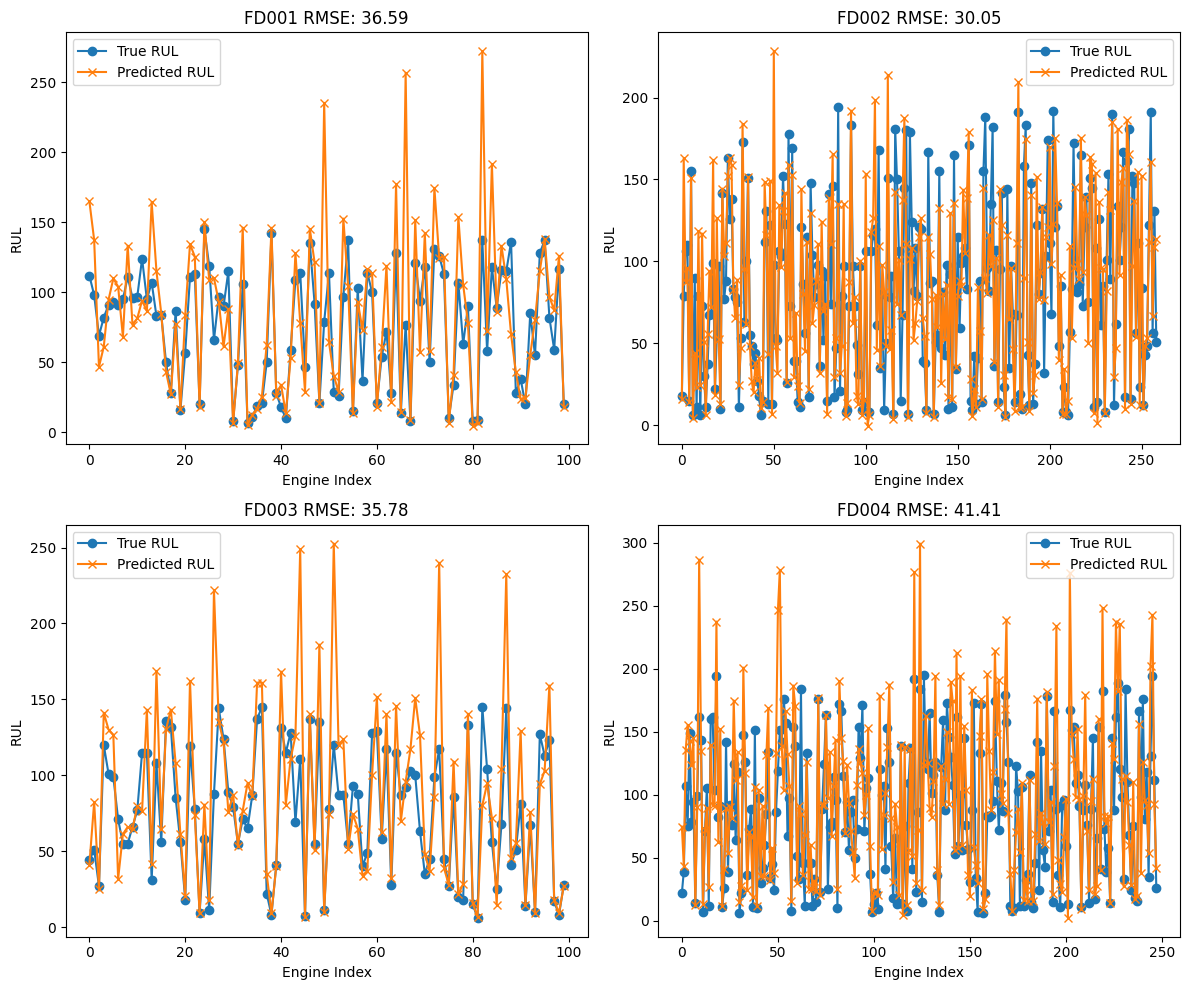

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, fd in zip(axes.flatten(), fds):
    res = results[fd]
    ax.plot(res["true_rul"], marker="o", label="True RUL")
    ax.plot(res["pred"], marker="x", label="Predicted RUL")
    ax.set_title(f"{fd} RMSE: {res['rmse']:.2f}")
    ax.set_xlabel("Engine Index")
    ax.set_ylabel("RUL")
    ax.legend()
plt.tight_layout()
plt.show()
